### ================================================================================================
| 주어진 데이터 셋 | 설명 | 
| ---- | ---- |
| train_users.csv | 분석에 사용될 메인 데이터 셋 | 
| sessions.csv  | 사용자의 웹 세션 로그 기록 데이터 셋 | 
| countries.csv | 여행 목적지 국가에 대한 통계 데이터 셋 | 
| age_gender_bkts.csv  | 사용자의 성별, 인구 등에 관한 데이터 셋 | 

| 사용할 데이터 셋 | 설명 | 
| ----- | ----- | 
| train_clean.csv | train_users.csv를 전처리한 데이터 셋  | 
| sessions_clean.csv | sessions.csv을 전처리하여 결측치, 이상치 처리 및 피처 엔지니어링 등을 위해 사용 | 
| countries.csv | 결측치, 이상치 처리 및 피처 엔지니어링 등을 위해 사용 |
| age_gender_bkts.csv | 결측치, 이상치 처리 및 피처 엔지니어링 등을 위해 사용 | 
| train_clean_with_session.csv | train_clean.csv와 sessions_clean.csv을 병합한 데이터 셋 | 
| train_clean_with_country.csv | train_clean.csv와 countries.csv을 병합한 데이터 셋 | 
| train_clean_with_two_datasets.csv | train_clean.csv 및 sessions_clean.csv 및 countries.csv을 병합한 데이터 셋 | 
### ================================================================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob 

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1.데이터 업로드

In [3]:
file_name = glob('data/*')
file_name

['data/countries.csv',
 'data/0_sample_submission_NDF.csv',
 'data/age_gender_bkts.csv',
 'data/0_test_users.csv',
 'data/train_users_2.csv',
 'data/sessions.csv']

In [4]:
train_df = pd.read_csv('data/train_users_2.csv')
sessions_df = pd.read_csv('data/sessions.csv')

countries_df = pd.read_csv('data/countries.csv')
age_gender_df = pd.read_csv('data/age_gender_bkts.csv')

# 2.데이터 요약과 통계량을 계산하는 함수 정의

## 2-1. 데이터 요약 함수 정의

- 각 컬럼에 대해 '데이터 타입', '변수 유형', '결측치 수', '결측치 비율', '고유값 수' 산정

In [5]:
def get_column_info(df, col):
    return {
        '변수명': col,
        '데이터 타입': df[col].dtype,
        '변수 유형': '숫자형' if pd.api.types.is_numeric_dtype(df[col]) else '범주형',
        '결측치 수': df[col].isnull().sum(),
        '결측치 비율': df[col].isnull().mean(),
        '고유값 수': df[col].nunique()
    }

def summary_statistics(df):
    columns = ['변수명', '데이터 타입', '변수 유형', '결측치 수', '결측치 비율', '고유값 수']
    variable_data = {col: [] for col in columns}

    for col in df.columns:
        col_info = get_column_info(df, col)
        for key in variable_data:
            variable_data[key].append(col_info[key])

    summary_df = pd.DataFrame(variable_data)
    summary_df = summary_df.reset_index(drop=True).T
    summary_df.columns = summary_df.iloc[0]

    return summary_df[1:]

## 2-2.수치형 데이터 통계량 함수 정의

- 각 컬럼에 대해 Count, Mean, Median, Mode, Std Dev, Variance, Skewness, Kurtosis, Min, Max, Q1, Q3, Outliers 산정

In [6]:
def get_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((series < lower_bound) | (series > upper_bound)).sum()

    return [outlier_count, lower_bound, upper_bound]

def get_numerical_statistics(series):
    return {
        'Count': series.count(),
        'Mean': series.mean(),
        'Median': series.median(),
        'Mode': series.mode().values[0] if not series.mode().empty else None,
        'Std Dev': series.std(),
        'Variance': series.var(),
        'Skewness': series.skew(),
        'Kurtosis': series.kurtosis(),
        'Min': series.min(),
        'Max': series.max(),
        'Q1': series.quantile(0.25),
        'Q3': series.quantile(0.75),
        'Outliers': get_outliers(series)[0]
    }

def numerical_summary(df):
    columns = ['변수명', 'Count', 'Mean', 'Median', 'Mode', 'Std Dev', 'Variance',
               'Skewness', 'Kurtosis', 'Min', 'Max', 'Q1', 'Q3', 'Outliers']
    numerical_data = {col: [] for col in columns}

    for col in df.select_dtypes(include=[np.number]).columns:
        stats = get_numerical_statistics(df[col])
        numerical_data['변수명'].append(col)
        for key in stats:
            numerical_data[key].append(stats[key])

    numerical_df = pd.DataFrame(numerical_data)
    numerical_df = numerical_df.reset_index(drop=True).T
    numerical_df.columns = numerical_df.iloc[0]

    return numerical_df[1:]

## 2-3.범주형 데이터 통계량 함수 정의

- 각 컬럼에 대해 Category, Count, Percentage 산정

In [7]:
def get_categorical_statistics(series, column_name):
    value_counts = series.value_counts()
    summary = value_counts.reset_index()
    summary.columns = ['Category', 'Count']
    summary['Percentage'] = (summary['Count'] / len(series)) * 100
    if len(summary) > 5:
        others = summary[5:].sum(numeric_only=True)
        others['Category'] = 'Others'
        summary = pd.concat([summary[:5], others.to_frame().T], ignore_index=True)
    summary.insert(0, '변수명', column_name)
    return summary

def categorical_summary(df):
    categorical_data = []

    for col in df.select_dtypes(include=['object', 'category']).columns:
        summary = get_categorical_statistics(df[col], col)
        categorical_data.append(summary)

    categorical_df = pd.concat(categorical_data, ignore_index=True)
    categorical_df = categorical_df.reset_index(drop=True)

    return categorical_df

# 3.train_df 검토 및 전처리

## 3-1. 데이터 검토

- age 컬럼: 결측치와 이상치 처리 필요
- date_first_booking컬럼, first_affiliate_tracked컬럼: 결측치 처리 필요
- gender 컬럼: unknown 처리 필요

In [8]:
train_df.shape

(213451, 16)

In [9]:
train_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [10]:
summary_statistics(train_df)

변수명,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
데이터 타입,object,object,int64,object,object,float64,object,int64,object,object,object,object,object,object,object,object
변수 유형,범주형,범주형,숫자형,범주형,범주형,숫자형,범주형,숫자형,범주형,범주형,범주형,범주형,범주형,범주형,범주형,범주형
결측치 수,0,0,0,124543,0,87990,0,0,0,0,0,6065,0,0,0,0
결측치 비율,0.0,0.0,0.0,0.583473,0.0,0.412226,0.0,0.0,0.0,0.0,0.0,0.028414,0.0,0.0,0.0,0.0
고유값 수,213451,1634,213451,1976,4,127,3,17,25,8,18,7,4,9,52,12


In [11]:
numerical_summary(train_df)

변수명,timestamp_first_active,age,signup_flow
Count,213451,125461,213451
Mean,20130850417367.257812,49.668335,3.267387
Median,20130911061308.0,34.0,0.0
Mode,20090319043255.0,30.0,0.0
Std Dev,9253717046.583824,155.666612,7.637707
Variance,85631279178236051456.0,24232.094039,58.334566
Skewness,-0.861578,12.422586,2.234366
Kurtosis,0.355882,153.568929,3.324444
Min,20090319043255.0,1.0,0.0
Max,20140630235824.0,2014.0,25.0


In [12]:
categorical_summary(train_df)

,변수명,Category,Count,Percentage
0,id,gxn3p5htnn,1,0.000468
1,id,umu2ra4v9z,1,0.000468
2,id,by6zlm19yp,1,0.000468
3,id,k185q1twol,1,0.000468
4,id,usvsw2yn8l,1,0.000468
5,id,Others,213446.0,99.997658
6,date_account_created,2014-05-13,674,0.315763
7,date_account_created,2014-06-24,670,0.313889
8,date_account_created,2014-06-25,636,0.297961
9,date_account_created,2014-05-20,632,0.296087


## 3-2.age 컬럼 전처리

- 전체 데이터의 약 41%가 결측치
- 18세에서 100세 사이의 값만 유효하다고 가정하고, 이 범위를 벗어나는 값(이상치)은 결측치로 처리
- LGBM 회귀모델을 통한 age 결측치 대체

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


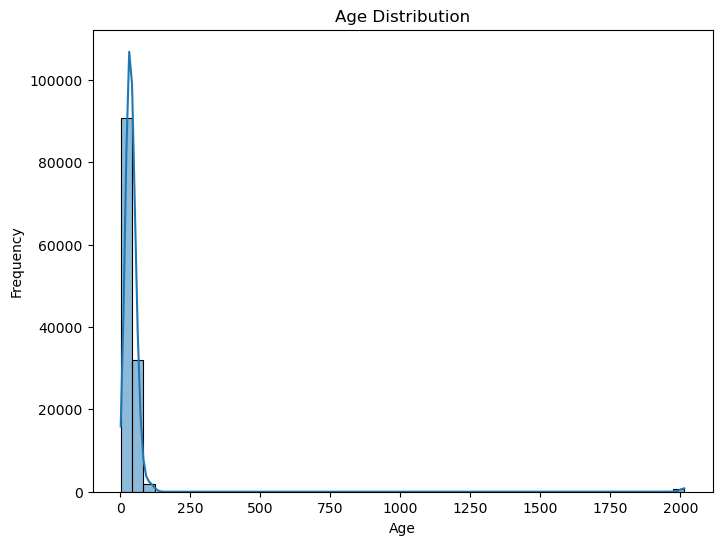

In [13]:
plt.figure(figsize=(8, 6))
sns.histplot(train_df['age'].dropna(), bins=50, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show();

In [14]:
train_df['age'] = train_df['age'].apply(lambda x: x if 18 <= x <= 100 else None)

In [15]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb

predict_age = train_df.copy()

# 나이 결측치 여부에 따라 데이터 분리
train_users_known_age = predict_age[predict_age['age'].notna()]
train_users_unknown_age = predict_age[predict_age['age'].isna()]

# 특성 및 타겟 분리
X_known_age = train_users_known_age.drop(columns=['id', 'age', 'date_account_created', 'timestamp_first_active', 'date_first_booking'])
y_known_age = train_users_known_age['age']
X_unknown_age = train_users_unknown_age.drop(columns=['id', 'age', 'date_account_created', 'timestamp_first_active', 'date_first_booking'])

# 범주형 변수와 수치형 변수 구분
categorical_features = X_known_age.select_dtypes(include=['object']).columns
numeric_features = X_known_age.select_dtypes(exclude=['object']).columns

# 범주형 변수 OneHot 인코딩
encoder = OneHotEncoder(handle_unknown='ignore')
X_known_age_cat = encoder.fit_transform(X_known_age[categorical_features])
X_unknown_age_cat = encoder.transform(X_unknown_age[categorical_features])

# 수치형 변수 스케일링
scaler = StandardScaler()
X_known_age_num = scaler.fit_transform(X_known_age[numeric_features])
X_unknown_age_num = scaler.transform(X_unknown_age[numeric_features])

# 인코딩된 범주형 변수와 스케일링된 수치형 변수 결합
X_known_age_processed = np.hstack((X_known_age_num, X_known_age_cat.toarray()))
X_unknown_age_processed = np.hstack((X_unknown_age_num, X_unknown_age_cat.toarray()))

# 훈련 및 테스트 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(X_known_age_processed, y_known_age, test_size=0.2, random_state=42)

# LightGBM 데이터셋 생성
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

# LightGBM 파라미터 설정
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# 모델 훈련
num_round = 1000
model = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data])

# 예측
predicted_ages = model.predict(X_unknown_age_processed, num_iteration=model.best_iteration)

# 예측된 나이를 정수로 변환하여 결측치 대체
train_df.loc[train_df['age'].isna(), 'age'] = np.round(predicted_ages).astype(int)



In [16]:
# 결측치 개수 확인
train_df['age'].isnull().sum()

0

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


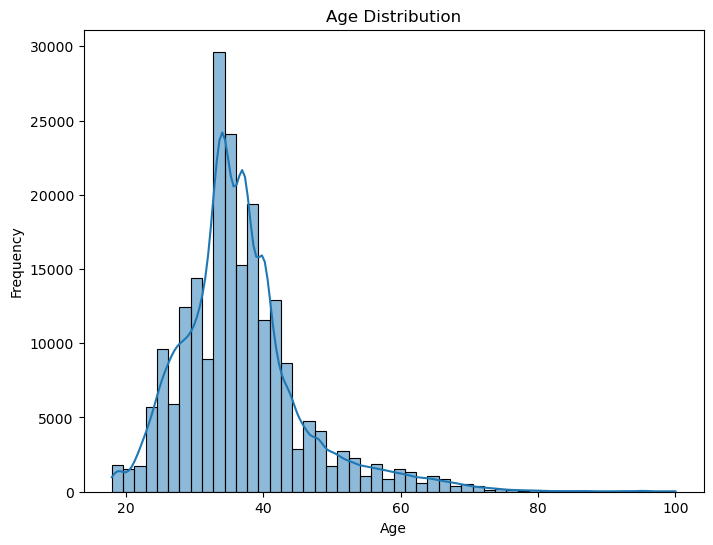

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(train_df['age'].dropna(), bins=50, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show();

## 3-3. date_first_booking 컬럼 전처리

- 전체 데이터의 약 58%가 결측치로 데이터 분석에 유용한 정보를 제공하지 않음
- 결측치는 예약을 한 적이 없는 사용자를 가리키며, country_destination 변수와 관련성이 낮을 수 있음
- date_first_booking 컬럼 삭제

In [18]:
train_df = train_df.drop('date_first_booking', axis=1)

## 3-4. first_affiliate_tracked 컬럼 전처리

- 전체 데이터의 약 2.8%가 결측치
- 가장 빈도가 높은 값으로 대체

In [19]:
most_frequent_first_affiliate_tracked = train_df['first_affiliate_tracked'].mode()[0]
train_df['first_affiliate_tracked'].fillna(most_frequent_first_affiliate_tracked, inplace=True)

## 3-5.gender 컬럼 전처리

- -unknown-을 unknown으로 대체
- 소문자로 변경
- age_gender_df 데이터를 이용하여 unknown 값을 비율에 따라 male, female, other로 대체

In [20]:
train_df['gender'] = train_df['gender'].replace('-unknown-', 'unknown')

In [21]:
train_df['gender'] = train_df['gender'].str.lower()

In [22]:
# age_bucket을 할당하는 함수 정의
def assign_age_bucket(age):
    if age < 5:
        return '0-4'
    elif age < 10:
        return '5-9'
    elif age < 15:
        return '10-14'
    elif age < 20:
        return '15-19'
    elif age < 25:
        return '20-24'
    elif age < 30:
        return '25-29'
    elif age < 35:
        return '30-34'
    elif age < 40:
        return '35-39'
    elif age < 45:
        return '40-44'
    elif age < 50:
        return '45-49'
    elif age < 55:
        return '50-54'
    elif age < 60:
        return '55-59'
    elif age < 65:
        return '60-64'
    elif age < 70:
        return '65-69'
    elif age < 75:
        return '70-74'
    elif age < 80:
        return '75-79'
    else:
        return '80-84'

In [23]:
# unknown 값을 비율에 따라 대체하는 함수 정의
def replace_unknown_gender(row):
    if row['gender'] == 'unknown':
        age_bucket = row['age_bucket']
        if age_bucket in age_gender_ratios.index:
            probabilities = age_gender_ratios.loc[age_bucket].values
            # 비율 배열과 항목 배열 크기 일치 확인
            if len(probabilities) == 3:
                return np.random.choice(['male', 'female', 'other'], p=probabilities)
            else:
                return np.random.choice(['male', 'female', 'other'])  # 기본 확률로 대체
        else:
            return np.random.choice(['male', 'female', 'other'])  # 기본 확률로 대체
    else:
        return row['gender']

In [24]:
# train_users_df에 age_bucket 열 추가
train_df['age_bucket'] = train_df['age'].apply(assign_age_bucket)

In [25]:
# age_bucket과 gender에 따른 사용자 수 계산
age_gender_counts = age_gender_df.groupby(['age_bucket', 'gender'])['population_in_thousands'].sum().unstack()

# 각 age_bucket에서 gender 비율 계산
age_gender_ratios = age_gender_counts.div(age_gender_counts.sum(axis=1), axis=0)

In [26]:
# gender 열의 unknown 값을 대체
train_df['gender'] = train_df.apply(replace_unknown_gender, axis=1)

## 3-6. first_browser 컬럼 전처리

- -unknown-을 unknown으로 대체
- 전체 데이터 중 unknown은 12.8%로 별도의 카데고리로 유지

In [27]:
train_df['first_browser'] = train_df['first_browser'].replace('-unknown-', 'unknown')

In [28]:
categorical_summary(train_df)

,변수명,Category,Count,Percentage
0,id,gxn3p5htnn,1,0.000468
1,id,umu2ra4v9z,1,0.000468
2,id,by6zlm19yp,1,0.000468
3,id,k185q1twol,1,0.000468
4,id,usvsw2yn8l,1,0.000468
5,id,Others,213446.0,99.997658
6,date_account_created,2014-05-13,674,0.315763
7,date_account_created,2014-06-24,670,0.313889
8,date_account_created,2014-06-25,636,0.297961
9,date_account_created,2014-05-20,632,0.296087


## 3-6. 전처리 완료한 train_cleaned.csv 다운로드

In [29]:
# train_cleaned = train_df
# train_cleaned.to_csv('train_clean.csv', index=False)

# 4.sessions_df 검토 및 병합

## 4-1.데이터 검토

- 모든 컬럼에 결측치 처리 필요

In [30]:
sessions_df.shape

(10567737, 6)

In [31]:
sessions_df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [32]:
summary_statistics(sessions_df)

변수명,user_id,action,action_type,action_detail,device_type,secs_elapsed
데이터 타입,object,object,object,object,object,float64
변수 유형,범주형,범주형,범주형,범주형,범주형,숫자형
결측치 수,34496,79626,1126204,1126204,0,136031
결측치 비율,0.003264,0.007535,0.10657,0.10657,0.0,0.012872
고유값 수,135483,359,10,155,14,337661


In [33]:
numerical_summary(sessions_df)

변수명,secs_elapsed
Count,10431706
Mean,19405.810751
Median,1147.0
Mode,0.0
Std Dev,88884.243208
Variance,7900408690.734015
Skewness,11.141939
Kurtosis,154.748944
Min,0.0
Max,1799977.0


In [34]:
categorical_summary(sessions_df)

,변수명,Category,Count,Percentage
0,user_id,mxqbh3ykxl,2722,0.025758
1,user_id,0hjoc5q8nf,2644,0.02502
2,user_id,mjbl6rrj52,2476,0.02343
3,user_id,l5lgm3w5pc,2424,0.022938
4,user_id,wg9413iaux,2362,0.022351
5,user_id,Others,10520613.0,99.554077
6,action,show,2768278,26.195561
7,action,index,843699,7.983724
8,action,search_results,725226,6.862642
9,action,personalize,706824,6.688509


## 4-2. user_id 컬럼 전처리

- user_id 컬럼: 결측치 행 삭제

In [35]:
userId_na_index = sessions_df[sessions_df['user_id'].isna()].index

In [36]:
userId_na_index

Index([    6715,     6716,     6717,     6718,    19921,    19922,    19923,
          19924,    19925,    19926,
       ...
       10556654, 10556655, 10556656, 10556657, 10556658, 10556659, 10556660,
       10556661, 10556662, 10556663],
      dtype='int64', length=34496)

In [37]:
sessions_df.drop(userId_na_index, axis=0, inplace=True)

## 4-3. action 컬럼, action_type 컬럼, action_detail 컬럼 전처리

- 결측치는 unknown으로 대체
- -unknown-을 unknown으로 대체

In [38]:
sessions_df[['action', 'action_type', 'action_detail']] = sessions_df[['action', 'action_type', 'action_detail']].fillna('unknown')

In [39]:
sessions_df['action'] = sessions_df['action'].replace('-unknown-', 'unknown')
sessions_df['action_type'] = sessions_df['action_type'].replace('-unknown-', 'unknown')
sessions_df['action_detail'] = sessions_df['action_detail'].replace('-unknown-', 'unknown')

## 4-4.secs_elapsed 컬럼 전처리

- 결측치는 0으로 대체

In [40]:
sessions_df['secs_elapsed'].fillna(0, inplace=True)

In [41]:
# 다운로드
# sessions_df.to_csv('sessions_clean.csv', index=False)

## 4-5. train_cleaned와 병합

In [42]:
session_aggregates = sessions_df.groupby('user_id').agg({
    'action': 'count',
    'action_type': 'nunique',
    'action_detail': 'nunique',
    'device_type': 'nunique',
    'secs_elapsed': 'sum'
}).reset_index()

# 열 이름 변경
session_aggregates.columns = ['user_id', 'action_count', 'unique_action_types', 'unique_action_details', 'unique_device_types', 'total_secs_elapsed']

In [43]:
session_aggregates.head()

,user_id,action_count,unique_action_types,unique_action_details,unique_device_types,total_secs_elapsed
0,00023iyk9l,40,7,14,2,867896.0
1,0010k6l0om,63,5,8,1,586543.0
2,001wyh0pz8,90,5,9,1,282965.0
3,0028jgx1x1,31,5,6,2,297010.0
4,002qnbzfs5,789,7,22,2,6487080.0


In [44]:
train_cleaned_with_session = pd.merge(train_df, session_aggregates, left_on='id', right_on='user_id', how='inner')

In [45]:
train_cleaned_with_session = train_cleaned_with_session.drop('user_id', axis=1)

In [46]:
print(train_cleaned_with_session.shape)
train_cleaned_with_session.head()

(73815, 21)


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_bucket,action_count,unique_action_types,unique_action_details,unique_device_types,total_secs_elapsed
0,d1mm9tcy42,2014-01-01,20140101000936,male,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,60-64,127,6,9,2,3427529.0
1,yo8nz8bqcq,2014-01-01,20140101001558,other,37.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,35-39,9,5,9,1,207842.0
2,4grx6yxeby,2014-01-01,20140101001639,other,44.0,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF,40-44,16,6,8,2,1135444.0
3,ncf87guaf0,2014-01-01,20140101002146,male,35.0,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,35-39,152,5,11,3,3755100.0
4,4rvqpxoh3h,2014-01-01,20140101002619,female,33.0,basic,25,en,direct,direct,untracked,iOS,iPhone,unknown,GB,30-34,8,1,1,1,2555.0


In [47]:
# 다운로드
# train_cleaned_with_session.to_csv('train_clean_with_session.csv', index=False)

# 5. countries_df 검토 및 병합

## 5-1. 데이터 검토

- 전처리 불요

In [48]:
countries_df.shape

(10, 7)

In [49]:
countries_df.head(3)

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61


In [50]:
# 데이터 요약: 데이터 타입, 유형, 결측치 수, 결측치 비율, 고윳값 수
summary_statistics(countries_df)

변수명,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
데이터 타입,object,float64,float64,float64,float64,object,float64
변수 유형,범주형,숫자형,숫자형,숫자형,숫자형,범주형,숫자형
결측치 수,0,0,0,0,0,0,0
결측치 비율,0.0,0.0,0.0,0.0,0.0,0.0,0.0
고유값 수,10,10,10,10,10,7,7


In [51]:
# 수치형 데이터 요약: 개수, 평균, 중간값, 최빈값, 표준편차, 분산, 왜도, 첨도, 최솟값, 최댓값, Q1, Q3, 아웃라이어
numerical_summary(countries_df)

변수명,lat_destination,lng_destination,distance_km,destination_km2,language_levenshtein_distance
Count,10,10,10,10,10
Mean,39.799398,-4.262446,7181.8978,2973734.1,50.499
Median,44.053092,-0.139014,7603.63265,431196.0,67.915
Mode,-26.853388,-96.818146,0.0,41543.0,0.0
Std Dev,24.739112,63.700585,3941.141734,4329619.177089,44.54169
Variance,612.023685,4057.764472,15532598.163681,18745602218614.546875,1983.962121
Skewness,-2.547514,0.564085,0.193594,1.096282,-0.326893
Kurtosis,7.365051,2.310956,2.321651,-0.922564,-2.194884
Min,-26.853388,-96.818146,0.0,41543.0,0.0
Max,62.393303,133.27516,15297.744,9984670.0,95.45


In [52]:
# 범주형 데이터 요약: 고윳값, 개수, 비율
categorical_summary(countries_df)

,변수명,Category,Count,Percentage
0,country_destination,AU,1,10.0
1,country_destination,CA,1,10.0
2,country_destination,DE,1,10.0
3,country_destination,ES,1,10.0
4,country_destination,FR,1,10.0
5,country_destination,Others,5.0,50.0
6,destination_language,eng,4,40.0
7,destination_language,deu,1,10.0
8,destination_language,spa,1,10.0
9,destination_language,fra,1,10.0


## 5-2. train_cleaned와 병합

In [53]:
train_cleaned_with_country = pd.merge(train_cleaned, countries_df, on='country_destination', how='left')

# NaN 값 처리
train_cleaned_with_country['country_destination'] = train_cleaned_with_country['country_destination'].fillna(train_cleaned_with_country['country_destination'])
train_cleaned_with_country[['lat_destination', 'lng_destination', 'distance_km', 'destination_km2', 'language_levenshtein_distance']] = train_cleaned_with_country[[
    'lat_destination', 'lng_destination', 'distance_km', 'destination_km2', 'language_levenshtein_distance']].fillna(0)
train_cleaned_with_country['destination_language '] = train_cleaned_with_country['destination_language '].fillna(train_cleaned_with_country['destination_language '].mode()[0])

In [54]:
train_cleaned_with_country.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,age_bucket,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,gxn3p5htnn,2010-06-28,20090319043255,female,38.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,35-39,0.000000,0.00000,0.0,0.0,eng,0.0
1,820tgsjxq7,2011-05-25,20090523174809,male,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF,35-39,0.000000,0.00000,0.0,0.0,eng,0.0
2,4ft3gnwmtx,2010-09-28,20090609231247,female,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US,55-59,36.966427,-95.84403,0.0,9826675.0,eng,0.0
3,bjjt8pjhuk,2011-12-05,20091031060129,female,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other,40-44,0.000000,0.00000,0.0,0.0,eng,0.0
4,87mebub9p4,2010-09-14,20091208061105,other,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,40-44,36.966427,-95.84403,0.0,9826675.0,eng,0.0


In [55]:
# 다운로드
# train_cleaned_with_country.to_csv('train_clean_with_country.csv', index=False)

# 6. age_gender_df 검토 

- 전처리 불요
- train_df 데이터의 age 컬럼의 결측값을 예측하는 데이터로 활용

In [56]:
age_gender_df.shape

(420, 5)

In [57]:
age_gender_df.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


In [58]:
# 데이터 요약: 데이터 타입, 유형, 결측치 수, 결측치 비율, 고윳값 수
summary_statistics(age_gender_df)

변수명,age_bucket,country_destination,gender,population_in_thousands,year
데이터 타입,object,object,object,float64,float64
변수 유형,범주형,범주형,범주형,숫자형,숫자형
결측치 수,0,0,0,0,0
결측치 비율,0.0,0.0,0.0,0.0,0.0
고유값 수,21,10,2,381,1


In [59]:
# 수치형 데이터 요약: 개수, 평균, 중간값, 최빈값, 표준편차, 분산, 왜도, 첨도, 최솟값, 최댓값, Q1, Q3, 아웃라이어
numerical_summary(age_gender_df)

변수명,population_in_thousands,year
Count,420,420
Mean,1743.133333,2015.0
Median,1090.5,2015.0
Mode,3.0,2015.0
Std Dev,2509.843202,0.0
Variance,6299312.898648,0.0
Skewness,2.853006,0.0
Kurtosis,7.535371,0.0
Min,0.0,2015.0
Max,11601.0,2015.0


In [60]:
# 범주형 데이터 요약: 고윳값, 개수, 비율
categorical_summary(age_gender_df)

,변수명,Category,Count,Percentage
0,age_bucket,100+,20,4.761905
1,age_bucket,45-49,20,4.761905
2,age_bucket,5-9,20,4.761905
3,age_bucket,10-14,20,4.761905
4,age_bucket,15-19,20,4.761905
5,age_bucket,Others,320.0,76.190476
6,country_destination,AU,42,10.0
7,country_destination,CA,42,10.0
8,country_destination,DE,42,10.0
9,country_destination,ES,42,10.0


# 7. 데이터 셋 3개 병합 (train_cleaned, session_df, countries_df)

In [61]:
train_cleaned_with_two_datasets = pd.merge(train_cleaned_with_session, countries_df, on='country_destination', how='left')

# NaN 값 처리
train_cleaned_with_two_datasets['country_destination'] = train_cleaned_with_two_datasets['country_destination'].fillna(train_cleaned_with_country['country_destination'])
train_cleaned_with_two_datasets[['lat_destination', 'lng_destination', 'distance_km', 'destination_km2', 'language_levenshtein_distance']] = train_cleaned_with_two_datasets[[
    'lat_destination', 'lng_destination', 'distance_km', 'destination_km2', 'language_levenshtein_distance']].fillna(0)
train_cleaned_with_two_datasets['destination_language '] = train_cleaned_with_two_datasets['destination_language '].fillna(train_cleaned_with_two_datasets['destination_language '].mode()[0])

In [62]:
#  다운로드
# train_cleaned_with_two_datasets.to_csv('train_clean_with_two_datasets.csv', index=False)